In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
# Import pyMC3 and also arviz for visualisation
import pymc as pm
import arviz as az
# Import the other core data science packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
from sklearn import datasets
from scipy.stats import norm
import statsmodels.formula.api as smf

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
import seaborn as sns

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Data

In [3]:
# True parameter values
alpha_, sigma_ = 1, 0.05
beta_ = [1]

# Size of dataset
size = 20

data = pd.DataFrame()
# Predictor variable
data['x1'] = np.linspace(0,1,size)

# Simulate outcome variable
data['y'] = alpha_ + beta_[0] * data['x1']
data['y_measure'] = data['y'] + rng.normal(size=size) * sigma_
data['outlier'] = False

# Adding one outlier:
index = data.index[int(size*0.60)]
data.loc[index,'outlier'] = True
data.loc[index,'y_measure']*=1.5

<Axes: xlabel='x1'>

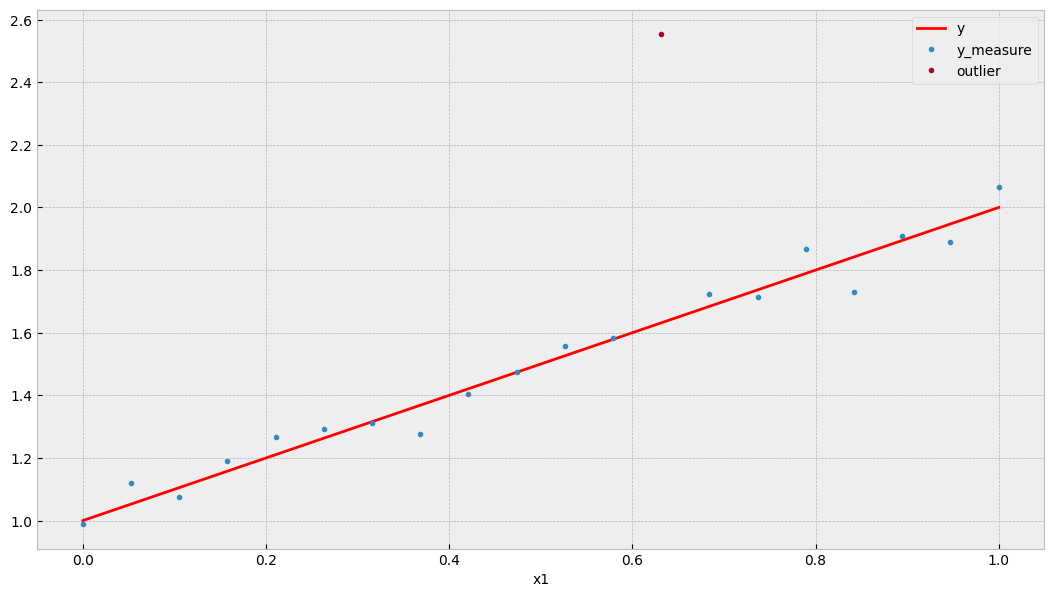

In [4]:
fig,ax=plt.subplots()
data.plot(x='x1', y='y', style='r-', ax=ax)

data_good = data.loc[~data['outlier']]
data_outliers = data.loc[data['outlier']]

data_good.plot(x='x1', y='y_measure', style='.', ax=ax)
data_outliers.plot(x='x1', y='y_measure', style='.', label='outlier', ax=ax)


## OLS regression

In [5]:
# OLS line
formula = 'y_measure ~ x1'
results_robust = smf.ols(formula, data=data_good).fit()

In [6]:
results_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              y_measure   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     631.2
Date:                Mon, 06 Mar 2023   Prob (F-statistic):           7.00e-15
Time:                        13:15:50   Log-Likelihood:                 29.983
No. Observations:                  19   AIC:                            -55.97
Df Residuals:                      17   BIC:                            -54.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0131      0.023     44.502      0.000       0.965       1.061
x1             0.9821      0.039     25.123      0.000       0.900       1.065
==============================================================================
Omnibus:                        1.529   Durbin-Watson:                   2.588
Prob(Omnibus):                  0.466   Jarque-Bera (JB):                1.025
Skew:                          -0.557   Prob(JB):                        0.599
Kurtosis:                       2.764   Cond. No.                         4.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
results_ols = smf.ols(formula, data=data).fit()
results_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              y_measure   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     43.12
Date:                Mon, 06 Mar 2023   Prob (F-statistic):           3.61e-06
Time:                        13:15:50   Log-Likelihood:                 3.2712
No. Observations:                  20   AIC:                            -2.542
Df Residuals:                      18   BIC:                           -0.5509
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0262      0.093     10.995      0.000       0.830       1.222
x1             1.0478      0.160      6.567      0.000       0.713       1.383
==============================================================================
Omnibus:                       46.419   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.779
Skew:                           3.673   Prob(JB):                     3.37e-40
Kurtosis:                      15.812   Cond. No.                         4.18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='x1'>

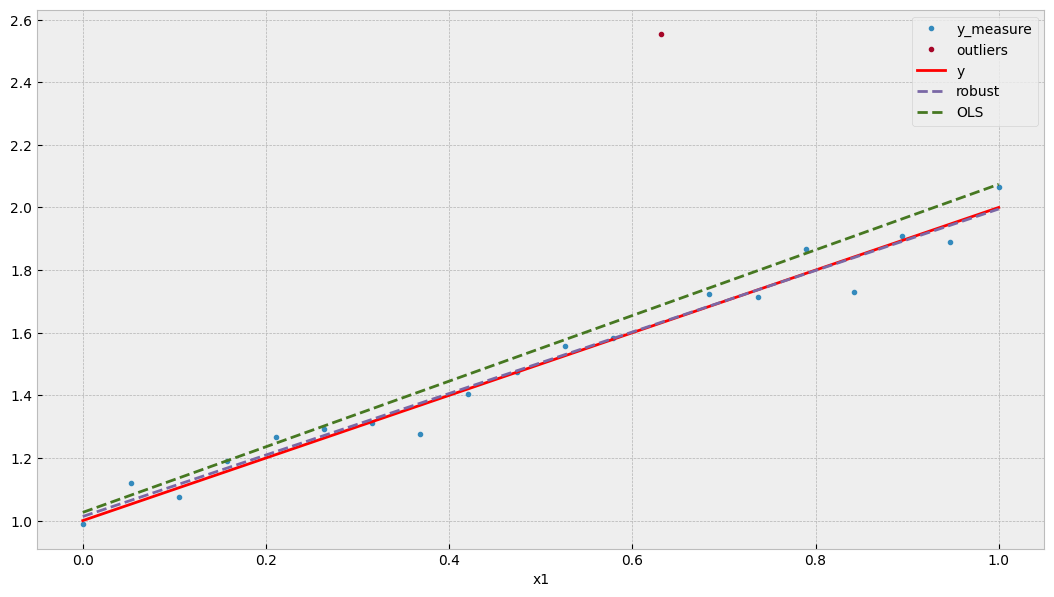

In [8]:
X = data[['x1']]
prediction = X.copy()

prediction['robust'] = results_robust.predict(X)
prediction['OLS'] = results_ols.predict(X)

fig,ax=plt.subplots(sharex=True)
data_good.plot(x='x1', y='y_measure', style='.', ax=ax)
data_outliers.plot(x='x1', y='y_measure', label='outliers', style='.', ax=ax)
data.plot(x='x1', y='y', style='r-', ax=ax)

prediction.plot(x='x1', y='robust', style='--', ax=ax)
prediction.plot(x='x1', y='OLS', style='--', ax=ax)

## Bayesian

In [9]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=alpha_, sigma=0.1)
    beta = pm.Normal("beta", mu=beta_, sigma=0.1, shape=1)
    sigma = pm.HalfNormal("sigma", sigma=sigma_)

    # Expected value of outcome
    mu = alpha + beta[0] * data['x1']

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=data['y_measure'])

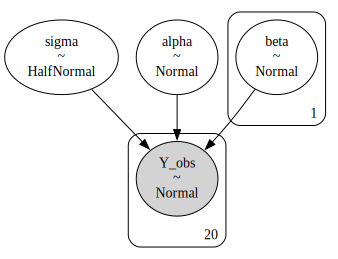

In [10]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

pm.model_to_graphviz(basic_model)

In [11]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample(draws=100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


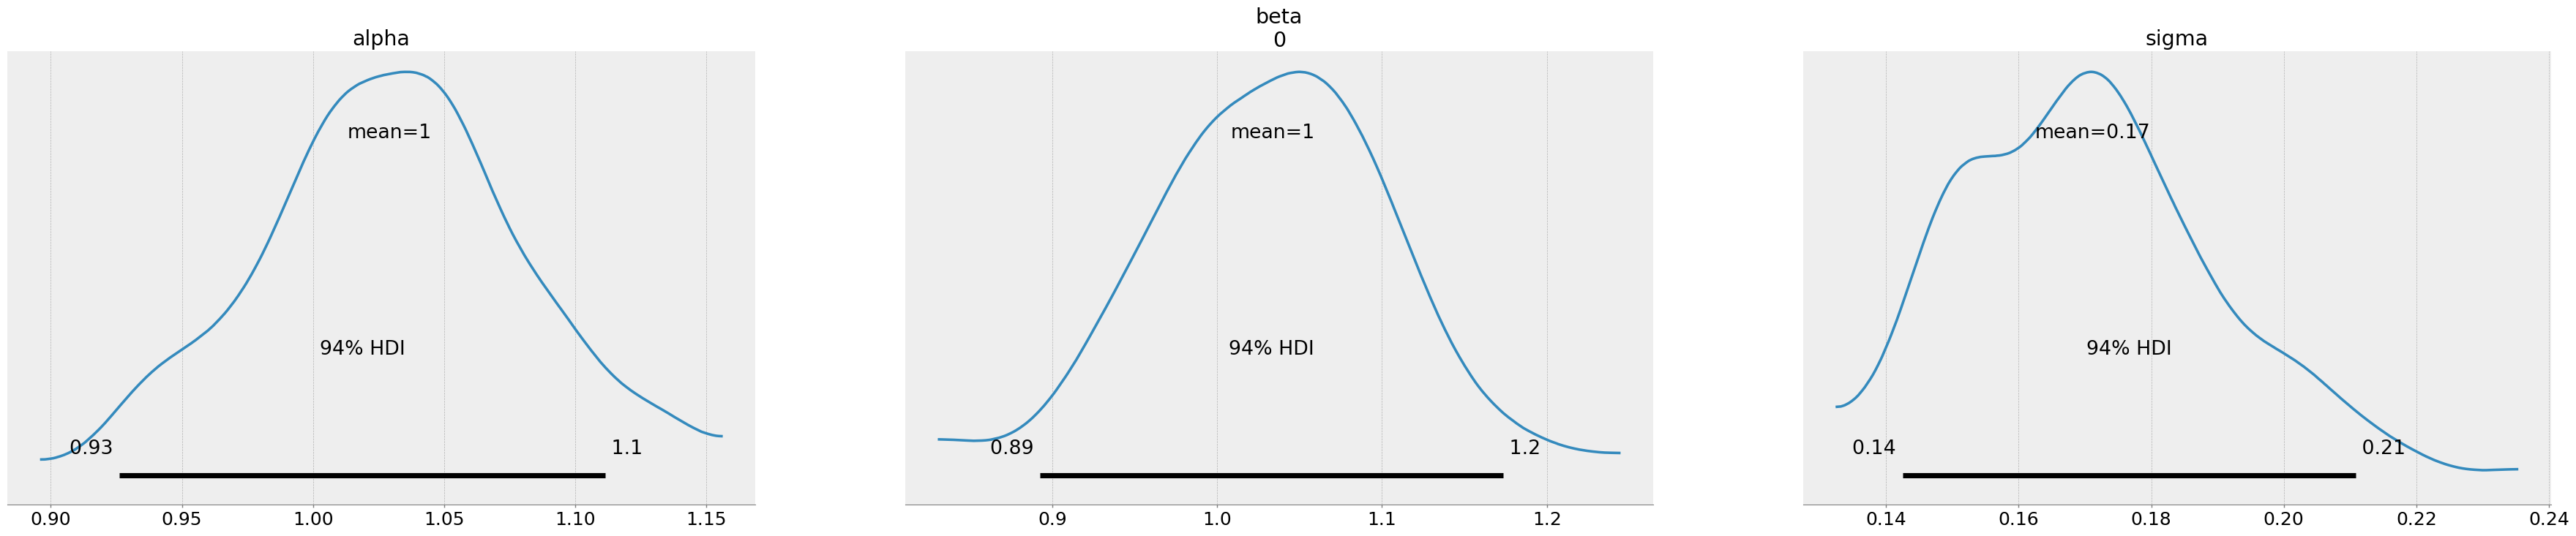

In [12]:
with basic_model:
    az.plot_posterior(idata,
                      var_names=['alpha', 'beta', 'sigma'],
                      textsize=18,
                      point_estimate='mean',
                      rope_color='black')

In [13]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.029,0.050,0.926,1.112,0.004,0.003,139.0,115.0,0.99
beta[0],1.034,0.074,0.893,1.173,0.006,0.004,144.0,114.0,1.01
sigma,0.171,0.019,0.142,0.211,0.002,0.001,119.0,134.0,1.00


In [14]:
with basic_model:   
    prior_samples = pm.sample_prior_predictive(samples=1000, var_names=["alpha", "beta"])

Sampling: [alpha, beta]


In [16]:
with basic_model:   
    y_test = pm.sample_posterior_predictive(idata, var_names=["alpha", "beta"])

Sampling: [alpha, beta]


In [19]:
y_test

Inference data with groups:
	> posterior_predictive
	> observed_data

In [35]:
a = prior_samples.prior.data_vars[key]
a.draw

<xarray.DataArray 'draw' (draw: 1000)>
array([  0,   1,   2, ..., 997, 998, 999])
Coordinates:
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [45]:
idata.posterior.data_vars['alpha'].data.mean()

1.0292794035493016

In [46]:
prediction['Bayes'] = idata.posterior.data_vars['alpha'].data.mean() + idata.posterior.data_vars['beta'][0].data.mean()*data['x1']

<Axes: xlabel='x1'>

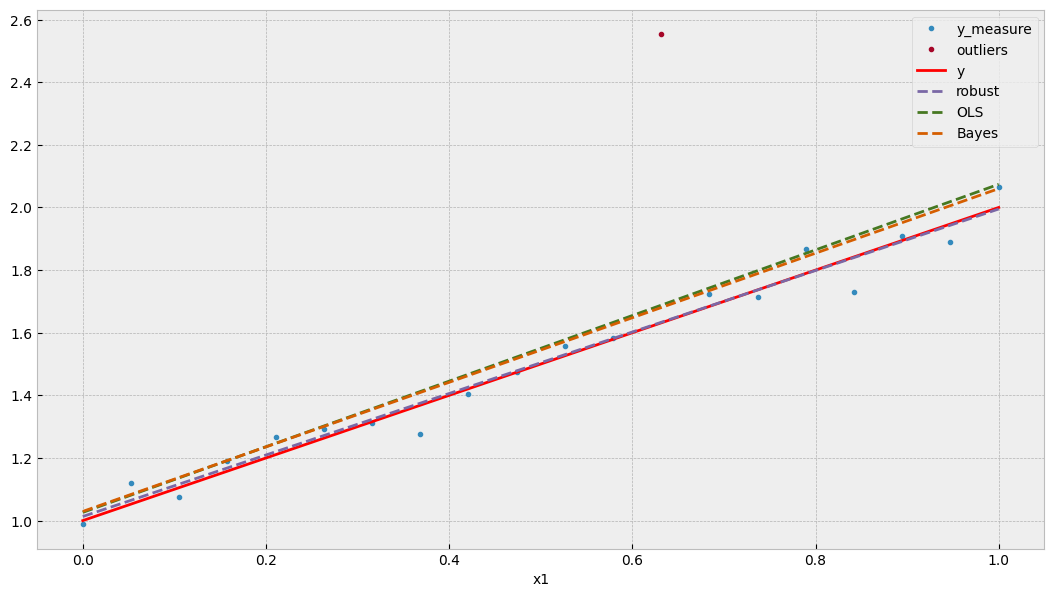

In [47]:
fig,ax=plt.subplots(sharex=True)
data_good.plot(x='x1', y='y_measure', style='.', ax=ax)
data_outliers.plot(x='x1', y='y_measure', label='outliers', style='.', ax=ax)
data.plot(x='x1', y='y', style='r-', ax=ax)

prediction.plot(x='x1', y='robust', style='--', ax=ax)
prediction.plot(x='x1', y='OLS', style='--', ax=ax)
prediction.plot(x='x1', y='Bayes', style='--', ax=ax)

In [48]:
basic_model_robust = pm.Model()

with basic_model_robust:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=alpha_, sigma=0.1)
    beta = pm.Normal("beta", mu=beta_, sigma=0.1, shape=1)
    sigma = pm.HalfNormal("sigma", sigma=sigma_)

    # Expected value of outcome
    mu = alpha + beta[0] * data['x1']
    
    ν = pm.Uniform("ν", 1, 10)
    
    # Likelihood (sampling distribution) of observations
    # Using Student's T-distribution makes the regression more robust, (I don't know why...)
    Y_obs = pm.StudentT("Y_obs", nu=ν, mu=mu, sigma=sigma, observed=data['y_measure'])

In [53]:
mu

Elemwise{add,no_inplace}.0

In [49]:
with basic_model_robust:
    # draw 1000 posterior samples
    trace_robust = pm.sample(draws=100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma, ν]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 56 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [50]:
prediction['Bayes robust'] = trace_robust.posterior.data_vars['alpha'].data.mean() + trace_robust.posterior.data_vars['beta'][0].data.mean()*data['x1']

<Axes: xlabel='x1'>

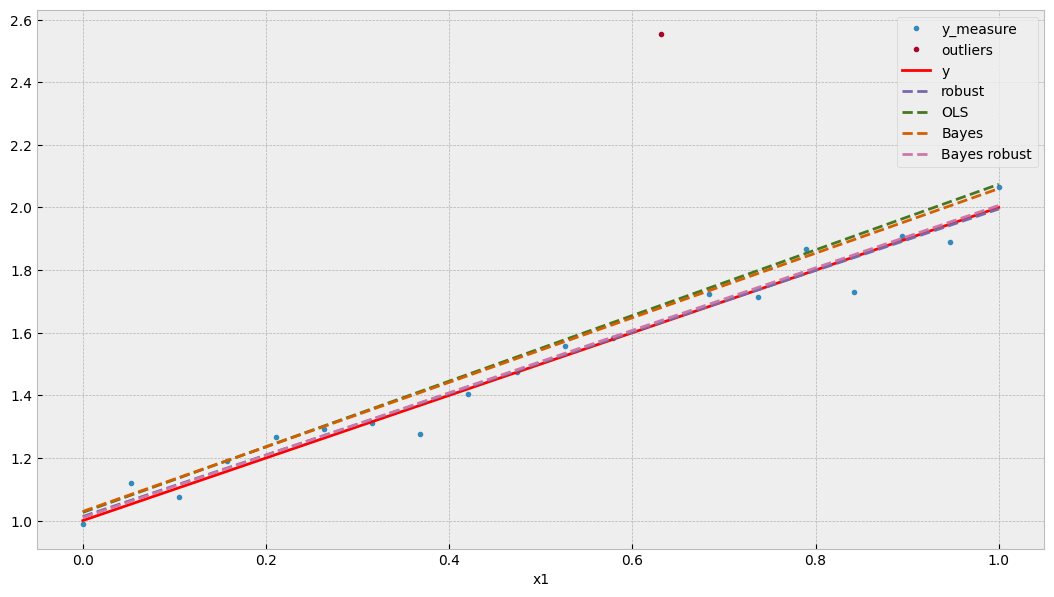

In [51]:
fig,ax=plt.subplots(sharex=True)
data_good.plot(x='x1', y='y_measure', style='.', ax=ax)
data_outliers.plot(x='x1', y='y_measure', label='outliers', style='.', ax=ax)
data.plot(x='x1', y='y', style='r-', ax=ax)

prediction.plot(x='x1', y='robust', style='--', ax=ax)
prediction.plot(x='x1', y='OLS', style='--', ax=ax)
prediction.plot(x='x1', y='Bayes', style='--', ax=ax)
prediction.plot(x='x1', y='Bayes robust', style='--', ax=ax)

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>]],
      dtype=object)

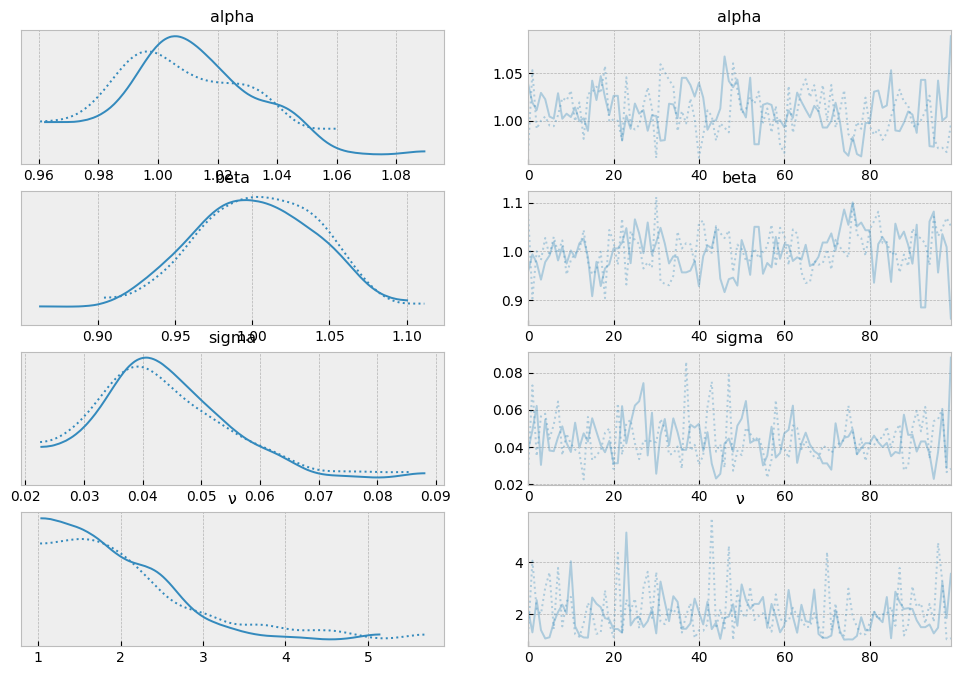

In [52]:
az.plot_trace(trace_robust)